In [8]:
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import sys
from itertools import combinations, product
sys.path.append('../')

import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table, unique, join
import papermill as pm
from astropy.time import Time
corr = __import__('11_corr')

In [9]:
from uvot import filters
from xrt import curves
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from table_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols, curves
from lightcurve import LightCurve

In [10]:
def line(x, m, c):
    return m*x+c

In [11]:
def load_df_prop(simbad_name, xrt_curve, uvot_filter, include_bad, include_UL):
    df = df_prop[(df_prop['simbad_name'] == simbad_name)
               & (df_prop['xrt_curve']   == xrt_curve)
               & (df_prop['uvot_filter'] == uvot_filter)
               & (df_prop['include_bad'] == include_bad)
               & (df_prop['include_UL']  == include_UL)]
    return df_prop

def load_corr_output(simbad_name, xrt_curve, uvot_filter, include_bad, include_UL):
    # Fix glob square bracket issue
    to_replace = {'[':'[[]',
                  ']':'[]]'}

    simbad_name_glob = simbad_name.translate(str.maketrans(to_replace))
    corr_output = glob(f'../lightcurves/correlation_output/*/tables/*{simbad_name_glob}*{xrt_curve}*{uvot_filter}*{include_bad}*{include_UL}*table_corr*')[0]
    
    df = pd.read_csv(corr_output)
    df['simbad_name'] = simbad_name
    df['xrt_curve']   = xrt_curve
    df['uvot_filter'] = uvot_filter
    df['include_bad'] = include_bad
    df['include_UL']  = include_UL
    return df

In [12]:
def plot_corr(simbad_name, xrt_curve, uvot_filter, include_bad, include_UL):
    
    # Savefile
    fn = f'../lightcurves/correlation_output/{simbad_name}/plots/{simbad_name},{xrt_curve},{uvot_filter},{include_bad},{include_UL}'
    if Path(f'{fn}.pdf').exists():
        print(f'{fn} exists! skipping...')
        return None
    
    ###############
    ## LOAD DATA ##
    ###############    
    df_prop     = load_df_prop(simbad_name, xrt_curve, uvot_filter, include_bad, include_UL)
    df_corr_out = load_corr_output(simbad_name, xrt_curve, uvot_filter, include_bad, include_UL)
    
    to_replace = {'[':'[[]',
                  ']':'[]]'}
    simbad_name_glob = simbad_name.translate(str.maketrans(to_replace))
    
    uvot_rate     = 'COI_SRC_RATE'
    uvot_rate_err = 'COI_SRC_RATE_ERR'
    xrt_rate      = 'Rate'
    
    if xrt_curve == 'FULL':
        fits_path = f'../lightcurves/joined/{simbad_name},{uvot_filter},curve_nosys_join.fits'
        xrt_rate_err = 'Ratepos'
    else:
        fits_path = f'../lightcurves/joined/{simbad_name},{uvot_filter},hardrat_join,{xrt_curve}.fits'
        xrt_rate_err = 'Error'
        
    tab = Table.read(fits_path)
    tables = corr.calc_subsets(tab)
    tab_5_sig        = tables['tab_5_sig']
    tab_UL           = tables['tab_UL']
    tab_no_UL        = tables['tab_no_UL']
    tab_BAD          = tables['tab_BAD']
    tab_no_BAD       = tables['tab_no_BAD']
    tab_UL_no_bad    = tables['tab_UL_no_bad']
    tab_no_UL_no_bad = tables['tab_no_UL_no_bad']

    
    ###############
    ## Plot Data ##
    ###############
    
    width = 15
    height = width * 5/3

    # Set up axis
    fig = plt.figure(figsize=(width,height), facecolor='white')

    # Plot Sequential XRT Curve
    ax_lc1 = fig.add_subplot(511)
    ax_lc1.errorbar(tab_no_UL['idx'], tab_no_UL[xrt_rate], yerr=tab_no_UL[xrt_rate_err], color='black', lw=1.0, capsize=1.0, marker='x', ls='none')
    ax_lc1.errorbar(tab_UL['idx'], tab_UL[xrt_rate], yerr=[tab_UL[xrt_rate], [0]*len(tab_UL)], color='red', lw=1.0, capsize=1.0, marker='v', ls='none')
    ax_lc1.set_ylabel(f'{curve_energies[xrt_curve]} keV Rate (ct/s)')
    ax_lc1.set_xlabel('# Datapoint')
    ax_lc1.set_title(f'{source_names_readable[simbad_name]} | {uvot_filter} | {xrt_curve} | include_UL={include_UL} | include_bad={include_bad}')

    ax_lc2 = fig.add_subplot(512)
    ax_lc2.errorbar(range(len(tab)), tab[uvot_rate], yerr=tab[uvot_rate_err], color='purple', lw=1.0, capsize=1.0, marker='.', ls='none')
    ax_lc2.set_ylabel(f'{uvot_filter} Count Rate (ct/s)')
    ax_lc2.set_xlabel('# Datapoint')

    ax_lc3 = fig.add_subplot(513)

    t0 = Time(tab['MJD_1'].min(), format='mjd')
    ax_lc3.errorbar(tab_no_UL['MJD_0'], tab_no_UL[xrt_rate], yerr=tab_no_UL[xrt_rate_err], color='black', lw=1.0, capsize=1.0, marker='x', ls='none')
    ax_lc3.errorbar(tab_UL['MJD_0'], tab_UL[xrt_rate], yerr=[tab_UL[xrt_rate], [0]*len(tab_UL)], color='red', lw=1.0, capsize=1.0, marker='v', ls='none')

    ax_lc3_2 = ax_lc3.twinx()
    ax_lc3_2.errorbar(tab['MJD_0'], tab[uvot_rate], yerr=tab[uvot_rate_err], color='purple', lw=1.0, capsize=1.0, marker='.', ls='none')

    ax_lc3.set_xlabel(f'Time since {str(t0.datetime.date())} (days)')
    ax_lc3.set_ylabel(f'{curve_energies[xrt_curve]} keV Rate (ct/s)')
    ax_lc3_2.set_ylabel(f'{uvot_filter} Count Rate (ct/s)')

    #ax_lc3.errorbar(tab[xrt_rate], tab_UL[xrt_rate], yerr=[tab_UL[xrt_rate], [0]*len(tab_UL)], color='black', lw=1.0, capsize=1.0, marker='v', ls='none')


    # Plot bestfits
    def plot_bestfit(ax):
        xmin, xmax = ax.get_xlim()[0], ax.get_xlim()[1]
        xrange = np.linspace(xmin,xmax,100)
        ystds = np.array([line(x, df_corr_out['m'], df_corr_out['c']).std() for x in xrange])
        m_mu = df_corr_out['m'].mean()
        c_mu = df_corr_out['c'].mean()
        y_est = line(xrange, m_mu, c_mu)

        ax.plot(xrange, y_est, color='red')
        ax.fill_between(xrange, y_est - ystds, y_est + ystds, alpha=0.5, color='grey', ec='#5a5a5a')
        ax.fill_between(xrange, y_est - 2*ystds, y_est + 2*ystds, alpha=0.5, color='grey', ec='#5a5a5a')
        ax.set_xlim(xmin, xmax)


    ax_corr1 = fig.add_subplot(5,3,10)
    ax_corr1.errorbar(x=tab_UL[xrt_rate], y=tab_UL[uvot_rate], xerr=[tab_UL[xrt_rate], [0]*len(tab_UL)], yerr=tab_UL[uvot_rate_err], ls='none', lw=1.0, color='red', marker='<')
    ax_corr1.errorbar(x=tab_no_UL[xrt_rate], y=tab_no_UL[uvot_rate], xerr=tab_no_UL[xrt_rate_err], yerr=tab_no_UL[uvot_rate_err], ls='none', lw=1.0, color='black')
    ax_corr1.set_xlabel(f'{curve_energies[xrt_curve]} keV Rate (ct/s)')
    ax_corr1.set_ylabel(f'{uvot_filter} Count Rate (ct/s)')

    plot_bestfit(ax_corr1)



    ax_corr2 = fig.add_subplot(5,3,12)
    ax_corr2.scatter(x=tab_UL[xrt_rate], y=tab_UL[uvot_rate], color='red', marker='<')
    ax_corr2.scatter(x=tab_no_UL[xrt_rate], y=tab_no_UL[uvot_rate], color='black', marker='x')

    ax_corr2.set_xlabel(f'{curve_energies[xrt_curve]} keV Rate (ct/s)')
    ax_corr2.set_ylabel(f'{uvot_filter} Count Rate (ct/s)')

    plot_bestfit(ax_corr2)


    def plt_hist(ax, df, val):
        mu  = np.mean(df[val])
        std = np.std(df[val])
        ax.hist(df[val], bins=100, histtype='step', color='black')
        ax.axvline(mu, color='red', alpha=0.8, label=f'{mu:.2f} $\pm$ {std:.2f}')  
        ax.axvline(mu+std,  ls='--', color='grey', alpha=0.8)
        ax.axvline(mu-std,  ls='--', color='grey', alpha=0.8)
        ax.legend()


    ax_dist1 = fig.add_subplot(5,3,13)
    plt_hist(ax_dist1, df_corr_out, 'r')
    ax_dist1.set_xlim(-1, 1)
    ax_dist1.set_xlabel('r')

    ax_dist2 = fig.add_subplot(5,3,14)
    plt_hist(ax_dist2, df_corr_out, 'm')
    ax_dist2.set_xlabel('m')

    ax_dist3 = fig.add_subplot(5,3,15)
    plt_hist(ax_dist3, df_corr_out, 'c')
    ax_dist3.set_xlabel('c')

    
    print(f'Saving file to: {fn}')
    plt.savefig(f'{fn}.pdf', bbox_inches='tight')
    plt.savefig(f'{fn}.png', bbox_inches='tight')
    plt.show()
    return fig


    

In [13]:
curve_energies = {'FULL' : '0.3 - 10.0',
                  'SOFT' : '0.3 - 1.5',
                  'HARD' : '1.5 - 10.0',
                  'HR'   : r'Ratio $\frac{(1.5 - 10.0)}{(0.3 - 1.5)}$'}

In [14]:
all_df = []
for f in tqdm(glob('../lightcurves/correlation_output/*/tables/*table_prop*')):
    sp = f.split('/')[-1].split(',')
    simbad_name = sp[0]
    xrt_curve   = sp[1]
    uvot_filter = sp[2]
    include_bad = sp[3]
    include_UL  = sp[4]
    
    df = pd.read_csv(f)
    df['simbad_name'] = simbad_name
    df['xrt_curve'] = xrt_curve
    df['uvot_filter'] = uvot_filter
    df['include_bad'] = include_bad
    df['include_UL']  = include_UL
    
    all_df.append(df)
df_prop = pd.concat(all_df)
df_prop.to_csv('../tables/simulation_n_obs.csv')
df_prop

100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:06<00:00, 190.37it/s]


,name,length,N_obs,N_bad,N_good,N_UL,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL
0,tab,98,98,0,98,2,Holmberg_II_X-1,FULL,U,False,False
1,tab_5_sig,98,98,0,98,2,Holmberg_II_X-1,FULL,U,False,False
2,tab_UL,2,2,0,2,2,Holmberg_II_X-1,FULL,U,False,False
3,tab_no_UL,96,96,0,96,0,Holmberg_II_X-1,FULL,U,False,False
4,tab_BAD,0,0,0,0,0,Holmberg_II_X-1,FULL,U,False,False
...,...,...,...,...,...,...,...,...,...,...,...
3,tab_no_UL,15,15,13,2,0,[SST2011]_J141939.39+564137.8,SOFT,UVM2,True,False
4,tab_BAD,13,13,13,0,0,[SST2011]_J141939.39+564137.8,SOFT,UVM2,True,False
5,tab_no_BAD,2,2,0,2,0,[SST2011]_J141939.39+564137.8,SOFT,UVM2,True,False
6,tab_UL_no_bad,0,0,0,0,0,[SST2011]_J141939.39+564137.8,SOFT,UVM2,True,False


In [15]:
all_df = []
for f in tqdm(glob('../lightcurves/correlation_output/*/tables/*table_prop*')):
    sp = f.split('/')[-1].split(',')
    simbad_name = sp[0]
    xrt_curve   = sp[1]
    uvot_filter = sp[2]
    include_bad = sp[3]
    include_UL  = sp[4]
    print(sp)
    plot_corr(simbad_name=simbad_name, xrt_curve=xrt_curve, uvot_filter=uvot_filter, include_bad=include_bad, include_UL=include_UL)

  3%|██▊                                                                             | 40/1159 [00:00<00:02, 398.66it/s]

['Holmberg_II_X-1', 'FULL', 'U', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/Holmberg_II_X-1/plots/Holmberg_II_X-1,FULL,U,False,False exists! skipping...
['Holmberg_II_X-1', 'FULL', 'U', 'False', 'True', 'table_prop.csv']
../lightcurves/correlation_output/Holmberg_II_X-1/plots/Holmberg_II_X-1,FULL,U,False,True exists! skipping...
['Holmberg_II_X-1', 'FULL', 'U', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/Holmberg_II_X-1/plots/Holmberg_II_X-1,FULL,U,True,False exists! skipping...
['Holmberg_II_X-1', 'FULL', 'U', 'True', 'True', 'table_prop.csv']
../lightcurves/correlation_output/Holmberg_II_X-1/plots/Holmberg_II_X-1,FULL,U,True,True exists! skipping...
['Holmberg_II_X-1', 'FULL', 'UVM2', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/Holmberg_II_X-1/plots/Holmberg_II_X-1,FULL,UVM2,False,False exists! skipping...
['Holmberg_II_X-1', 'FULL', 'UVM2', 'False', 'True', 'table_prop.csv']
../lightcurves/correlation_outp

 12%|█████████▎                                                                     | 137/1159 [00:00<00:02, 460.43it/s]

../lightcurves/correlation_output/M82_X-2/plots/M82_X-2,HARD,UVM2,False,False exists! skipping...
['M82_X-2', 'HARD', 'UVM2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/M82_X-2/plots/M82_X-2,HARD,UVM2,True,False exists! skipping...
['M82_X-2', 'HARD', 'UVW1', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/M82_X-2/plots/M82_X-2,HARD,UVW1,False,False exists! skipping...
['M82_X-2', 'HARD', 'UVW1', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/M82_X-2/plots/M82_X-2,HARD,UVW1,True,False exists! skipping...
['M82_X-2', 'HARD', 'UVW2', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/M82_X-2/plots/M82_X-2,HARD,UVW2,False,False exists! skipping...
['M82_X-2', 'HARD', 'UVW2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/M82_X-2/plots/M82_X-2,HARD,UVW2,True,False exists! skipping...
['M82_X-2', 'HARD', 'V', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/M82

 20%|████████████████                                                               | 236/1159 [00:00<00:01, 477.29it/s]

../lightcurves/correlation_output/NAME_M83_ULX-1/plots/NAME_M83_ULX-1,FULL,UVW1,True,False exists! skipping...
['NAME_M83_ULX-1', 'FULL', 'UVW1', 'True', 'True', 'table_prop.csv']
../lightcurves/correlation_output/NAME_M83_ULX-1/plots/NAME_M83_ULX-1,FULL,UVW1,True,True exists! skipping...
['NAME_M83_ULX-1', 'HARD', 'U', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_M83_ULX-1/plots/NAME_M83_ULX-1,HARD,U,False,False exists! skipping...
['NAME_M83_ULX-1', 'HARD', 'U', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_M83_ULX-1/plots/NAME_M83_ULX-1,HARD,U,True,False exists! skipping...
['NAME_M83_ULX-1', 'HARD', 'UVM2', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_M83_ULX-1/plots/NAME_M83_ULX-1,HARD,UVM2,False,False exists! skipping...
['NAME_M83_ULX-1', 'HARD', 'UVM2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_M83_ULX-1/plots/NAME_M83_ULX-1,HARD,UVM2,True,False exists! skippi

 29%|██████████████████████▉                                                        | 337/1159 [00:00<00:01, 491.31it/s]

../lightcurves/correlation_output/NAME_NGC_1365-X1/plots/NAME_NGC_1365-X1,FULL,UVW2,True,False exists! skipping...
['NAME_NGC_1365-X1', 'FULL', 'V', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_1365-X1/plots/NAME_NGC_1365-X1,FULL,V,True,False exists! skipping...
['NAME_NGC_1365-X1', 'HARD', 'B', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_1365-X1/plots/NAME_NGC_1365-X1,HARD,B,True,False exists! skipping...
['NAME_NGC_1365-X1', 'HARD', 'U', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_1365-X1/plots/NAME_NGC_1365-X1,HARD,U,True,False exists! skipping...
['NAME_NGC_1365-X1', 'HARD', 'UVM2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_1365-X1/plots/NAME_NGC_1365-X1,HARD,UVM2,True,False exists! skipping...
['NAME_NGC_1365-X1', 'HARD', 'UVW1', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_1365-X1/plots/NAME_NGC_1365-X1,HARD,UVW1

 38%|█████████████████████████████▋                                                 | 436/1159 [00:00<00:01, 477.32it/s]

../lightcurves/correlation_output/NAME_NGC_7090_ULX3/plots/NAME_NGC_7090_ULX3,SOFT,U,True,False exists! skipping...
['NAME_NGC_7090_ULX3', 'SOFT', 'UVM2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_7090_ULX3/plots/NAME_NGC_7090_ULX3,SOFT,UVM2,True,False exists! skipping...
['NAME_NGC_7090_ULX3', 'SOFT', 'UVW1', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_7090_ULX3/plots/NAME_NGC_7090_ULX3,SOFT,UVW1,True,False exists! skipping...
['NAME_NGC_7793_P13', 'FULL', 'U', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_7793_P13/plots/NAME_NGC_7793_P13,FULL,U,False,False exists! skipping...
['NAME_NGC_7793_P13', 'FULL', 'U', 'False', 'True', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_7793_P13/plots/NAME_NGC_7793_P13,FULL,U,False,True exists! skipping...
['NAME_NGC_7793_P13', 'FULL', 'U', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_7793_P13/plots/

 46%|████████████████████████████████████▎                                          | 532/1159 [00:01<00:01, 475.32it/s]

../lightcurves/correlation_output/NAME_NGC_925_ULX-2/plots/NAME_NGC_925_ULX-2,HARD,UVW1,False,False exists! skipping...
['NAME_NGC_925_ULX-2', 'HARD', 'UVW1', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_925_ULX-2/plots/NAME_NGC_925_ULX-2,HARD,UVW1,True,False exists! skipping...
['NAME_NGC_925_ULX-2', 'HARD', 'UVW2', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_925_ULX-2/plots/NAME_NGC_925_ULX-2,HARD,UVW2,False,False exists! skipping...
['NAME_NGC_925_ULX-2', 'HARD', 'UVW2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_925_ULX-2/plots/NAME_NGC_925_ULX-2,HARD,UVW2,True,False exists! skipping...
['NAME_NGC_925_ULX-2', 'HR', 'UVM2', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NAME_NGC_925_ULX-2/plots/NAME_NGC_925_ULX-2,HR,UVM2,False,False exists! skipping...
['NAME_NGC_925_ULX-2', 'HR', 'UVM2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/NA

 54%|██████████████████████████████████████████▊                                    | 628/1159 [00:01<00:01, 469.23it/s]

../lightcurves/correlation_output/RX_J133001+47137/plots/RX_J133001+47137,FULL,U,False,True exists! skipping...
['RX_J133001+47137', 'FULL', 'U', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/RX_J133001+47137/plots/RX_J133001+47137,FULL,U,True,False exists! skipping...
['RX_J133001+47137', 'FULL', 'U', 'True', 'True', 'table_prop.csv']
../lightcurves/correlation_output/RX_J133001+47137/plots/RX_J133001+47137,FULL,U,True,True exists! skipping...
['RX_J133001+47137', 'FULL', 'UVM2', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/RX_J133001+47137/plots/RX_J133001+47137,FULL,UVM2,False,False exists! skipping...
['RX_J133001+47137', 'FULL', 'UVM2', 'False', 'True', 'table_prop.csv']
../lightcurves/correlation_output/RX_J133001+47137/plots/RX_J133001+47137,FULL,UVM2,False,True exists! skipping...
['RX_J133001+47137', 'FULL', 'UVM2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/RX_J133001+47137/plots/RX_J133001+47137,FULL,U

 63%|█████████████████████████████████████████████████▍                             | 726/1159 [00:01<00:00, 475.43it/s]

../lightcurves/correlation_output/SS433/plots/SS433,HARD,U,True,False exists! skipping...
['SS433', 'HARD', 'UVW1', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/SS433/plots/SS433,HARD,UVW1,False,False exists! skipping...
['SS433', 'HARD', 'UVW1', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/SS433/plots/SS433,HARD,UVW1,True,False exists! skipping...
['SS433', 'HARD', 'UVW2', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/SS433/plots/SS433,HARD,UVW2,False,False exists! skipping...
['SS433', 'HARD', 'UVW2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/SS433/plots/SS433,HARD,UVW2,True,False exists! skipping...
['SS433', 'HARD', 'V', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/SS433/plots/SS433,HARD,V,False,False exists! skipping...
['SS433', 'HARD', 'V', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/SS433/plots/SS433,HARD,V,True,False exists! skip

 71%|████████████████████████████████████████████████████████▎                      | 827/1159 [00:01<00:00, 488.20it/s]

../lightcurves/correlation_output/[LB2005]_NGC_253_X9/plots/[LB2005]_NGC_253_X9,SOFT,U,False,False exists! skipping...
['[LB2005]_NGC_253_X9', 'SOFT', 'U', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LB2005]_NGC_253_X9/plots/[LB2005]_NGC_253_X9,SOFT,U,True,False exists! skipping...
['[LB2005]_NGC_5236_X11', 'FULL', 'U', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LB2005]_NGC_5236_X11/plots/[LB2005]_NGC_5236_X11,FULL,U,False,False exists! skipping...
['[LB2005]_NGC_5236_X11', 'FULL', 'U', 'False', 'True', 'table_prop.csv']
../lightcurves/correlation_output/[LB2005]_NGC_5236_X11/plots/[LB2005]_NGC_5236_X11,FULL,U,False,True exists! skipping...
['[LB2005]_NGC_5236_X11', 'FULL', 'U', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LB2005]_NGC_5236_X11/plots/[LB2005]_NGC_5236_X11,FULL,U,True,False exists! skipping...
['[LB2005]_NGC_5236_X11', 'FULL', 'U', 'True', 'True', 'table_prop.csv']
../lightcurves/correlation_o

 80%|██████████████████████████████████████████████████████████████▉                | 923/1159 [00:01<00:00, 419.74it/s]

../lightcurves/correlation_output/[LB2005]_NGC_6946_ULX3/plots/[LB2005]_NGC_6946_ULX3,HR,UVW2,False,False exists! skipping...
['[LB2005]_NGC_6946_ULX3', 'HR', 'UVW2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LB2005]_NGC_6946_ULX3/plots/[LB2005]_NGC_6946_ULX3,HR,UVW2,True,False exists! skipping...
['[LB2005]_NGC_6946_ULX3', 'HR', 'V', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LB2005]_NGC_6946_ULX3/plots/[LB2005]_NGC_6946_ULX3,HR,V,False,False exists! skipping...
['[LB2005]_NGC_6946_ULX3', 'HR', 'V', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LB2005]_NGC_6946_ULX3/plots/[LB2005]_NGC_6946_ULX3,HR,V,True,False exists! skipping...
['[LB2005]_NGC_6946_ULX3', 'SOFT', 'B', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LB2005]_NGC_6946_ULX3/plots/[LB2005]_NGC_6946_ULX3,SOFT,B,False,False exists! skipping...
['[LB2005]_NGC_6946_ULX3', 'SOFT', 'B', 'True', 'False', 'table_prop.csv']
../li

 87%|███████████████████████████████████████████████████████████████████▉          | 1010/1159 [00:02<00:00, 405.69it/s]

../lightcurves/correlation_output/[LM2005]_NGC_3031_ULX1/plots/[LM2005]_NGC_3031_ULX1,FULL,V,False,False exists! skipping...
['[LM2005]_NGC_3031_ULX1', 'FULL', 'V', 'False', 'True', 'table_prop.csv']
../lightcurves/correlation_output/[LM2005]_NGC_3031_ULX1/plots/[LM2005]_NGC_3031_ULX1,FULL,V,False,True exists! skipping...
['[LM2005]_NGC_3031_ULX1', 'FULL', 'V', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LM2005]_NGC_3031_ULX1/plots/[LM2005]_NGC_3031_ULX1,FULL,V,True,False exists! skipping...
['[LM2005]_NGC_3031_ULX1', 'FULL', 'V', 'True', 'True', 'table_prop.csv']
../lightcurves/correlation_output/[LM2005]_NGC_3031_ULX1/plots/[LM2005]_NGC_3031_ULX1,FULL,V,True,True exists! skipping...
['[LM2005]_NGC_3031_ULX1', 'HARD', 'B', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LM2005]_NGC_3031_ULX1/plots/[LM2005]_NGC_3031_ULX1,HARD,B,False,False exists! skipping...
['[LM2005]_NGC_3031_ULX1', 'HARD', 'B', 'True', 'False', 'table_prop.csv']
../l

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1111/1159 [00:02<00:00, 452.19it/s]

../lightcurves/correlation_output/[LM2005]_NGC_4395_ULX1/plots/[LM2005]_NGC_4395_ULX1,SOFT,UVW2,False,False exists! skipping...
['[LM2005]_NGC_4395_ULX1', 'SOFT', 'UVW2', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LM2005]_NGC_4395_ULX1/plots/[LM2005]_NGC_4395_ULX1,SOFT,UVW2,True,False exists! skipping...
['[LM2005]_NGC_4395_ULX1', 'SOFT', 'V', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LM2005]_NGC_4395_ULX1/plots/[LM2005]_NGC_4395_ULX1,SOFT,V,False,False exists! skipping...
['[LM2005]_NGC_4395_ULX1', 'SOFT', 'V', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LM2005]_NGC_4395_ULX1/plots/[LM2005]_NGC_4395_ULX1,SOFT,V,True,False exists! skipping...
['[LM2005]_NGC_4559_ULX1', 'FULL', 'B', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[LM2005]_NGC_4559_ULX1/plots/[LM2005]_NGC_4559_ULX1,FULL,B,False,False exists! skipping...
['[LM2005]_NGC_4559_ULX1', 'FULL', 'B', 'False', 'True', 'table_pr

100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:02<00:00, 459.31it/s]

../lightcurves/correlation_output/[SRW2006b]_NGC_55_ULX/plots/[SRW2006b]_NGC_55_ULX,FULL,U,False,True exists! skipping...
['[SRW2006b]_NGC_55_ULX', 'FULL', 'U', 'True', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[SRW2006b]_NGC_55_ULX/plots/[SRW2006b]_NGC_55_ULX,FULL,U,True,False exists! skipping...
['[SRW2006b]_NGC_55_ULX', 'FULL', 'U', 'True', 'True', 'table_prop.csv']
../lightcurves/correlation_output/[SRW2006b]_NGC_55_ULX/plots/[SRW2006b]_NGC_55_ULX,FULL,U,True,True exists! skipping...
['[SRW2006b]_NGC_55_ULX', 'FULL', 'UVM2', 'False', 'False', 'table_prop.csv']
../lightcurves/correlation_output/[SRW2006b]_NGC_55_ULX/plots/[SRW2006b]_NGC_55_ULX,FULL,UVM2,False,False exists! skipping...
['[SRW2006b]_NGC_55_ULX', 'FULL', 'UVM2', 'False', 'True', 'table_prop.csv']
../lightcurves/correlation_output/[SRW2006b]_NGC_55_ULX/plots/[SRW2006b]_NGC_55_ULX,FULL,UVM2,False,True exists! skipping...
['[SRW2006b]_NGC_55_ULX', 'FULL', 'UVM2', 'True', 'False', 'table_prop.csv']
../li

In [9]:
tab = Table.read('../lightcurves/joined/Holmberg_II_X-1,U,curve_nosys_join.fits')
mjd_min = 59274 # mar 2021
tab = tab[tab['MJD_2'] > 59274]

In [10]:
tab[['MJD_2', 'COI_SRC_RATE', 'COI_SRC_RATE_ERR', 'NSIGMA', 'Rate', 'Ratepos', 'BAD', 'UL']]
#.write('HoII_MJD_59274_XRT_UVOT.dat', format='ascii', overwrite=True)

MJD_2,COI_SRC_RATE,COI_SRC_RATE_ERR,NSIGMA,Rate,Ratepos,BAD,UL
,ct / s,ct / s,,,,,
float64,float32,float32,float32,float64,float64,bool,bool
59275.977601718,4.8262906,0.09156032,54.052002,0.052142,0.01051779,False,False
59277.8263826278,4.62186,0.07517885,62.95438,0.03430726,0.006730812,False,False
59279.8911154692,4.5445786,0.07032978,66.16256,0.0339084,0.006641566,False,False
59281.0838965606,4.652805,0.0732822,65.045616,0.04362193,0.007583067,False,False
59281.6796845734,4.66283,0.07749824,61.64426,0.04678043,0.008150135,False,False
59283.8037651463,4.540375,0.08018555,57.9748,0.04280872,0.008894126,False,False
59285.1339881011,4.544578,0.07788988,59.73726,0.04727526,0.008436825,False,False
59285.2675681359,4.6039243,0.08039181,58.65138,0.03286053,0.008091525,False,False


In [11]:
tab

MET,EXTNAME,TSTART,TSTOP,EXPOSURE,TELAPSE,TIME,SRC_AREA,BKG_AREA,STD_AREA,PLATE_SCALE,RAW_TOT_CNTS,RAW_TOT_CNTS_ERR,RAW_BKG_CNTS,RAW_BKG_CNTS_ERR,RAW_STD_CNTS,RAW_STD_CNTS_ERR,RAW_TOT_RATE,RAW_TOT_RATE_ERR,RAW_BKG_RATE,RAW_BKG_RATE_ERR,RAW_STD_RATE,RAW_STD_RATE_ERR,COI_STD_FACTOR,COI_STD_FACTOR_ERR,COI_BKG_FACTOR,COI_BKG_FACTOR_ERR,COI_TOT_RATE,COI_TOT_RATE_ERR,COI_BKG_RATE,COI_BKG_RATE_ERR,COI_SRC_RATE,COI_SRC_RATE_ERR,AP_FACTOR,AP_FACTOR_ERR,AP_COI_SRC_RATE,AP_COI_SRC_RATE_ERR,LSS_FACTOR,LSS_RATE,LSS_RATE_ERR,SENSCORR_FACTOR,SENSCORR_RATE,SENSCORR_RATE_ERR,CORR_RATE,CORR_RATE_ERR,AB_MAG,AB_MAG_ERR,AB_MAG_ERR_STAT,AB_MAG_ERR_SYS,AB_MAG_BKG,AB_MAG_BKG_ERR_STAT,AB_MAG_BKG_ERR_SYS,AB_MAG_BKG_ERR,AB_MAG_LIM,AB_MAG_LIM_SIG,AB_MAG_COI_LIM,AB_FLUX_AA,AB_FLUX_AA_ERR_STAT,AB_FLUX_AA_ERR_SYS,AB_FLUX_AA_ERR,AB_FLUX_AA_BKG,AB_FLUX_AA_BKG_ERR_STAT,AB_FLUX_AA_BKG_ERR_SYS,AB_FLUX_AA_BKG_ERR,AB_FLUX_AA_LIM,AB_FLUX_AA_COI_LIM,AB_FLUX_HZ,AB_FLUX_HZ_ERR_STAT,AB_FLUX_HZ_ERR_SYS,AB_FLUX_HZ_ERR,AB_FLUX_HZ_BKG,AB_FLUX_HZ_BKG_ERR_STAT,AB_FLUX_HZ_BKG_ERR_SYS,AB_FLUX_HZ_BKG_ERR,AB_FLUX_HZ_LIM,AB_FLUX_HZ_COI_LIM,MAG,MAG_ERR,MAG_ERR_STAT,MAG_ERR_SYS,MAG_BKG,MAG_BKG_ERR_STAT,MAG_BKG_ERR_SYS,MAG_BKG_ERR,MAG_LIM,MAG_LIM_SIG,MAG_COI_LIM,FLUX_AA,FLUX_AA_ERR_STAT,FLUX_AA_ERR_SYS,FLUX_AA_ERR,FLUX_AA_BKG,FLUX_AA_BKG_ERR_STAT,FLUX_AA_BKG_ERR_SYS,FLUX_AA_BKG_ERR,FLUX_AA_LIM,FLUX_AA_COI_LIM,FLUX_HZ,FLUX_HZ_ERR_STAT,FLUX_HZ_ERR_SYS,FLUX_HZ_ERR,FLUX_HZ_BKG,FLUX_HZ_BKG_ERR_STAT,FLUX_HZ_BKG_ERR_SYS,FLUX_HZ_BKG_ERR,FLUX_HZ_LIM,FLUX_HZ_COI_LIM,COI_RATE_LIMIT,CORR_RATE_LIMIT,FILTER,RA,DEC,DETX,DETY,NSIGMA,FRAMTIME,SATURATED,SYS_ERR,SRCEXP,BKGEXP,OBSID,MJD_1,YEAR,MJD_0,FLAG_AB_MAG_99,FLAG_UPPER_LIM,FLAG_AB_MAG_ERR>2,FLAG_AB_MAG_>10_<30,MJD_2,T_+ve,T_-ve,Rate,Ratepos,Rateneg,MODE,BAD,UL,BAND
s,,s,s,s,s,s,arcsec2,arcsec2,arcsec2,arcsec / pix,ct,ct,ct,ct,ct,ct,ct / s,ct / s,ct / (arcsec2 s),ct / (arcsec2 s),ct / s,ct / s,,,,,ct / s,ct / s,ct / (arcsec2 s),ct / (arcsec2 s),ct / s,ct / s,,,ct / s,ct / s,,ct / s,ct / s,,ct / s,ct / s,ct / s,ct / s,mag,mag,mag,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag,sigma,mag,erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A cm2 s),erg / (A cm2 s),mjy,mjy,mjy,mjy,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy,mjy,mag,mag,mag,mag,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag / arcsec2,mag,sigma,mag,erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A arcsec2 cm2 s),erg / (A cm2 s),erg / (A cm2 s),mjy,mjy,mjy,mjy,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy/arcsec2,mjy,mjy,ct / s,ct / s,,deg,deg,pix,pix,,s,,,s,s,,s,,s,,,,,,,,,,,,,,
float64,bytes12,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float64,float64,float32,float32,float32,float32,int16,bool,float32,float32,bytes11,float64,float64,float64,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,bytes2,bool,bool,bytes4
636420495.37181,U,636420149.90348,636420840.84014,680.0392,690.93665,0.0,78.656494,706.7613,78.656494,1.004,3585.365,58.138725,378

Text(0, 0.5, 'UVOT UVM2 RATE')

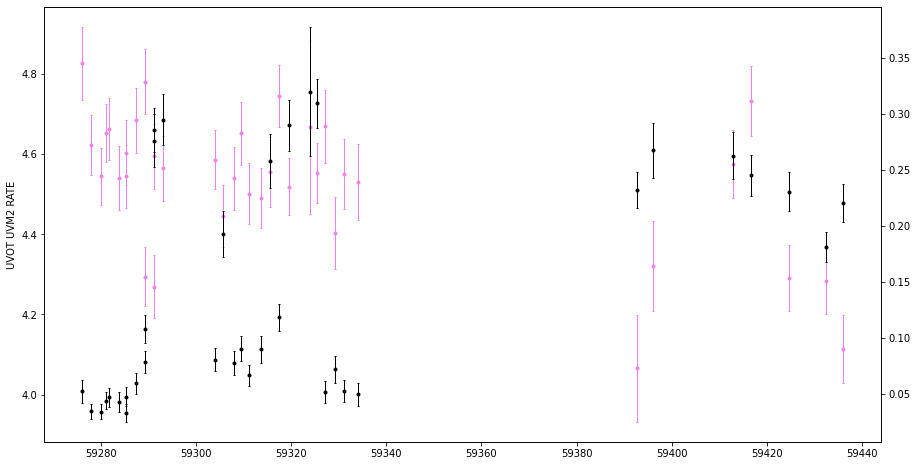

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()
ax.errorbar(tab['MJD_2'], tab['COI_SRC_RATE'], yerr=tab['COI_SRC_RATE_ERR'], ls='none', color='violet', lw=1.0, capsize=1.0, marker='.')
ax2.errorbar(tab['MJD_2'], tab['Rate'], yerr=tab['Ratepos'], ls='none', color='black', lw=1.0, capsize=1.0, marker='.')
ax.set_ylabel('XRT RATE')
ax.set_ylabel('UVOT UVM2 RATE')
